In [1]:
# Standard Library Imports
import re
import warnings
import logging


# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties

# Text Processing
import hazm
from hazm import *
from urlextract import URLExtract
import emoji
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from tqdm import tqdm

# Machine Learning - Model Selection and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier, SGDClassifier, Perceptron

# Suppressing Warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../../../Data/Farsi/2. Synthetic/synthetic_farsi_sms.csv", encoding='UTF-8')
df

message label
0     "سلام، یادم رفت بهت بگم، امتحان فیزیک رو انداخ...   ham
1     مهلت استفاده از تسهیلات بانکی شما رو به پایانه...  spam
2       کلاس ساعت ۱۰ تشکیل میشه، یادم رفت بهت بگم! 🤦‍♀️   ham
3                  وایسا دم در، زود بیا! منم دارم میام.   ham
4     امروز تولد مامانمه! چی‌کار کنیم سورپرایزش کنیم...   ham
...                                                 ...   ...
1909              کلاس امروز رو فهمیدی؟ من که هنگ کردم!   ham
1910  فروش ویژه پاییزی! تخفیف 70% در تمامی محصولات! ...  spam
1911                   سلام، شام چی داریم امشب؟ گرسنمه!   ham
1912                   باید برم باشگاه. بعدا زنگ میزنم.   ham
1913  سلام! امشب فیلم چی ببینیم؟ یه چیزی باشه که آدم...   ham

[1914 rows x 2 columns]

In [3]:
df.shape

(1914, 2)

In [4]:
# Check for duplicates and remove them if found
if df.duplicated().sum() > 0:
    print("Found duplicate rows. Removing them...")
    df = df.drop_duplicates()

In [5]:
# Check for missing values
missing_values = df.isna().sum()
if missing_values.any():
    print("Found missing values. Removing them...")
    df = df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  1914 non-null   object
 1   label    1914 non-null   object
dtypes: object(2)
memory usage: 30.0+ KB


In [7]:
# rename columns names
df.rename(columns={"label":"Class", "message":"Text"}, inplace=True)

In [8]:
# adding some usfule columns to the dataset

# number of words in a message
df['NO_words'] = df['Text'].apply(lambda x:len(hazm.word_tokenize(x)))

# number of characters in a message
df['NO_characters'] = df['Text'].apply(len)

# number of sentence in message
df['NO_sentences'] = df['Text'].apply(lambda x:len(hazm.sent_tokenize(x)))

# number of emojis in sentece
df['NO_emojis'] = df['Text'].apply(lambda x: emoji.emoji_count(x))

In [9]:
df.head()

Text Class  NO_words  \
0  "سلام، یادم رفت بهت بگم، امتحان فیزیک رو انداخ...   ham        18   
1  مهلت استفاده از تسهیلات بانکی شما رو به پایانه...  spam        25   
2    کلاس ساعت ۱۰ تشکیل میشه، یادم رفت بهت بگم! 🤦‍♀️   ham        12   
3               وایسا دم در، زود بیا! منم دارم میام.   ham        11   
4  امروز تولد مامانمه! چی‌کار کنیم سورپرایزش کنیم...   ham        13   

   NO_characters  NO_sentences  NO_emojis  
0             71             2          0  
1            108             3          0  
2             47             2          1  
3             36             2          0  
4             61             3          0

In [10]:
# Descriptive statistics of text features
df.describe()

NO_words  NO_characters  NO_sentences    NO_emojis
count  1914.000000    1914.000000   1914.000000  1914.000000
mean     18.433124      74.879310      2.507315     0.132184
std       7.175201      30.983691      0.805885     0.403563
min       3.000000       8.000000      1.000000     0.000000
25%      12.000000      47.000000      2.000000     0.000000
50%      18.000000      72.500000      2.000000     0.000000
75%      24.000000     102.000000      3.000000     0.000000
max      46.000000     173.000000      5.000000     3.000000

In [11]:
# Descriptive statistics of text features for HAM messages
df[df['Class'] == "ham"][['NO_characters', 'NO_words', 'NO_sentences', 'NO_emojis']].describe()

NO_characters    NO_words  NO_sentences   NO_emojis
count     955.000000  955.000000    955.000000  955.000000
mean       48.481675   12.534031      2.123560    0.109948
std        12.895908    3.233026      0.658296    0.322879
min        13.000000    5.000000      1.000000    0.000000
25%        39.000000   10.000000      2.000000    0.000000
50%        47.000000   12.000000      2.000000    0.000000
75%        57.000000   15.000000      2.000000    0.000000
max       100.000000   25.000000      5.000000    2.000000

In [12]:
# Descriptive statistics of text features for SPAM messages
df[df['Class'] == "spam"][['NO_characters', 'NO_words', 'NO_sentences', 'NO_emojis']].describe()

NO_characters    NO_words  NO_sentences   NO_emojis
count     959.000000  959.000000    959.000000  959.000000
mean      101.166840   24.307612      2.889468    0.154327
std        19.103752    4.812589      0.756519    0.469486
min         8.000000    3.000000      1.000000    0.000000
25%        90.000000   21.000000      2.000000    0.000000
50%       102.000000   24.000000      3.000000    0.000000
75%       113.000000   27.000000      3.000000    0.000000
max       173.000000   46.000000      5.000000    3.000000

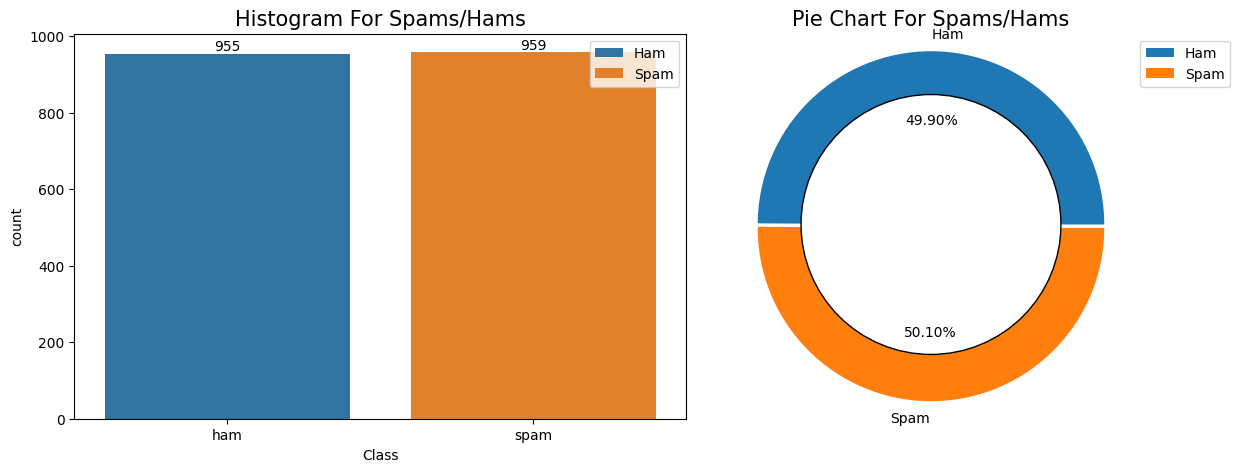

In [13]:
# Calculate number of each class (ham or spam)
spam_count = df['Class'].value_counts()['spam']
ham_count = df['Class'].value_counts()['ham']

# Plotting
labels = ['Ham', 'Spam']
plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Class', hue='Class', alpha=1)
plt.legend(labels)
plt.title('Histogram For Spams/Hams', size=15)

# Annotate histogram with exact counts
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Pie Chart
plt.subplot(1, 2, 2)
sizes = [ham_count, spam_count]
explode = [0, 0.02]
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.2f%%')
plt.axis('equal')
plt.legend(labels)
circle = plt.Circle(xy=(0, 0), radius=0.75, facecolor='white', edgecolor='black')
plt.gca().add_artist(circle)
plt.title('Pie Chart For Spams/Hams', size=15)

# Adjust layout to bring subplots closer together
plt.subplots_adjust(wspace= -0.1)  # Reduce the value to bring plots closer

plt.savefig('../../../Data/Farsi/2. Synthetic/F_Spam_vs_Ham_distribution.png', format='png', dpi=1000)

plt.show()


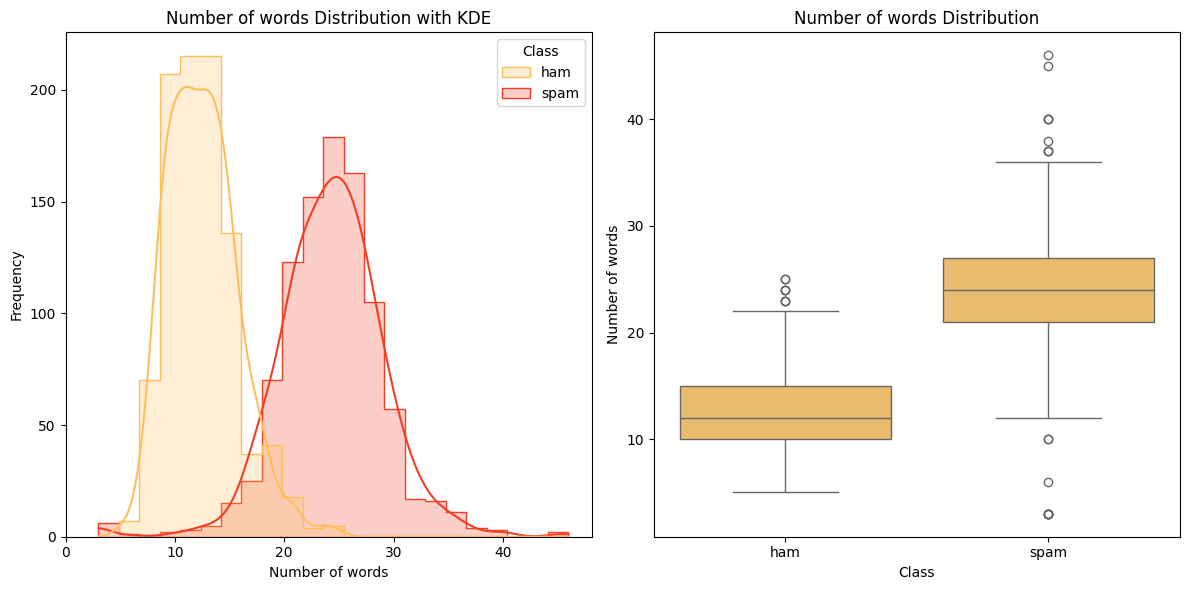

In [14]:
plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.histplot(data=df, x='NO_words', hue='Class', kde=True, element='step')
plt.title('Number of words Distribution with KDE')
plt.xticks(range(0, df['NO_words'].max() + 1, 10))  # Adjust the step size as needed
plt.xlabel('Number of words')
plt.ylabel('Frequency')

# Second subplot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_words', data=df)
plt.title('Number of words Distribution')
plt.xlabel('Class')
plt.ylabel('Number of words')

# Adjust layout
plt.tight_layout()

plt.savefig('../../../Data/Farsi/2. Synthetic/F_Number of words.png', format='png', dpi=1000)

# Show the plots
plt.show()

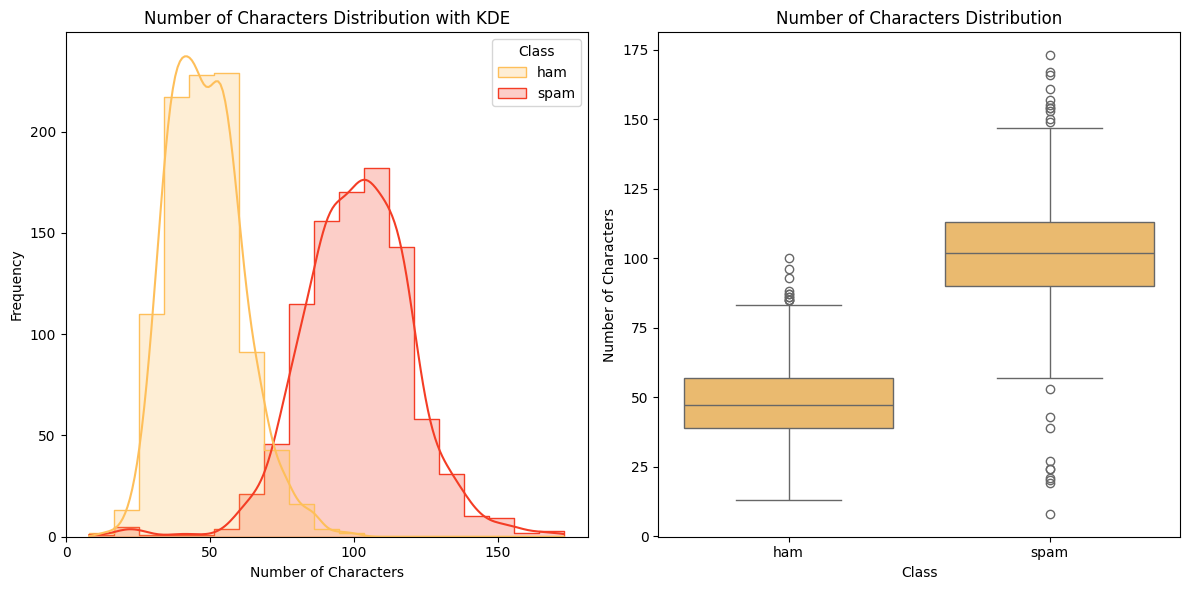

In [15]:
plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.histplot(data=df, x='NO_characters', hue='Class', kde=True, element='step')
plt.title('Number of Characters Distribution with KDE')
plt.xticks(range(0, df['NO_characters'].max() + 1, 50))  # Adjust the step size as needed
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

# Second subplot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_characters', data=df)
plt.title('Number of Characters Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Characters')

# Adjust layout
plt.tight_layout()

plt.savefig('../../../Data/Farsi/2. Synthetic/F_Number of Characters.png', format='png', dpi=1000)

# Show the plots
plt.show()

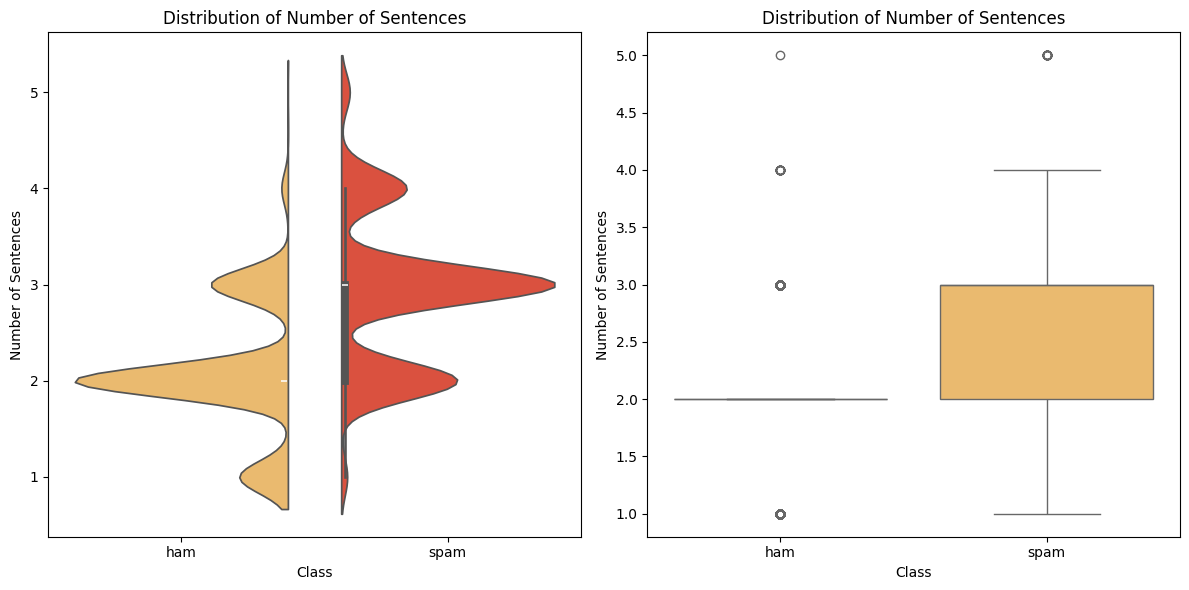

In [16]:

plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot - Violin Plot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.violinplot(data=df, x='Class', y='NO_sentences', hue='Class', split=True)
plt.title('Distribution of Number of Sentences')
plt.xlabel('Class')
plt.ylabel('Number of Sentences')

# Second subplot - Box Plot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_sentences', data=df)
plt.title('Distribution of Number of Sentences')
plt.xlabel('Class')
plt.ylabel('Number of Sentences')

# Adjust layout
plt.tight_layout()

plt.savefig('../../../Data/Farsi/2. Synthetic/F_Number of Sentences.png', format='png', dpi=1000)

# Show the plots
plt.show()

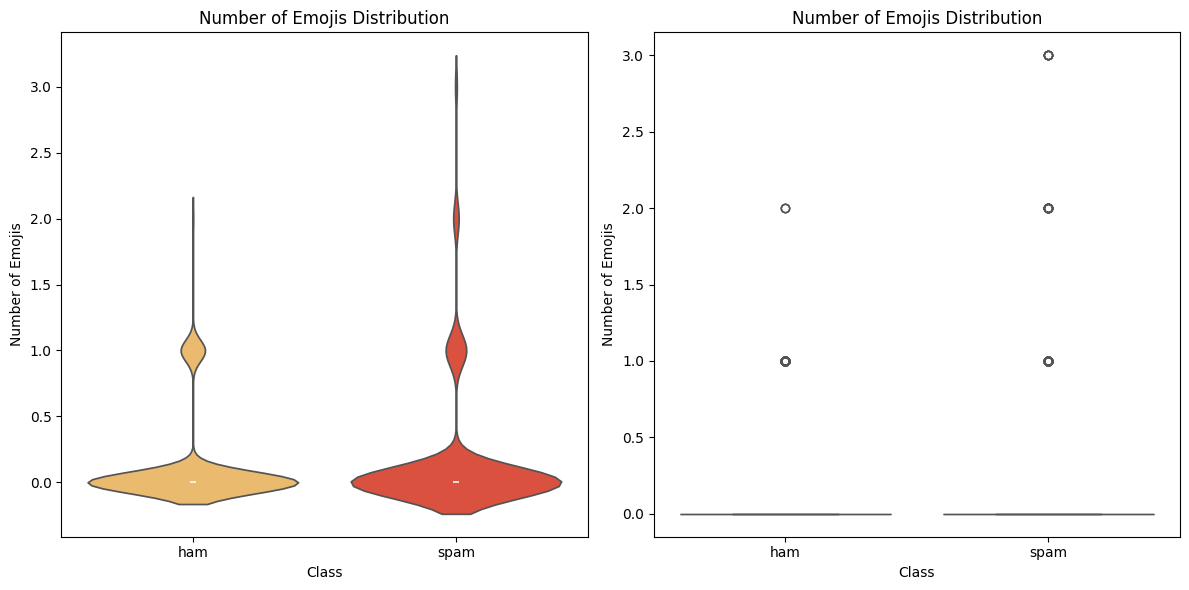

In [17]:
plt.figure(figsize=(12, 6))

# Subplot for emoji distribution using violin plot
plt.subplot(1, 2, 1)
sns.violinplot(x='Class', y='NO_emojis', data=df, palette=red_palette)
plt.title('Number of Emojis Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Emojis')

# Subplot for emoji distribution by class using box plot
plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='NO_emojis', data=df, palette=red_palette)
plt.title('Number of Emojis Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Emojis')

plt.tight_layout()

plt.savefig('../../../Data/Farsi/2. Synthetic/F_Number of Emojis.png', format='png', dpi=1000)

plt.show()



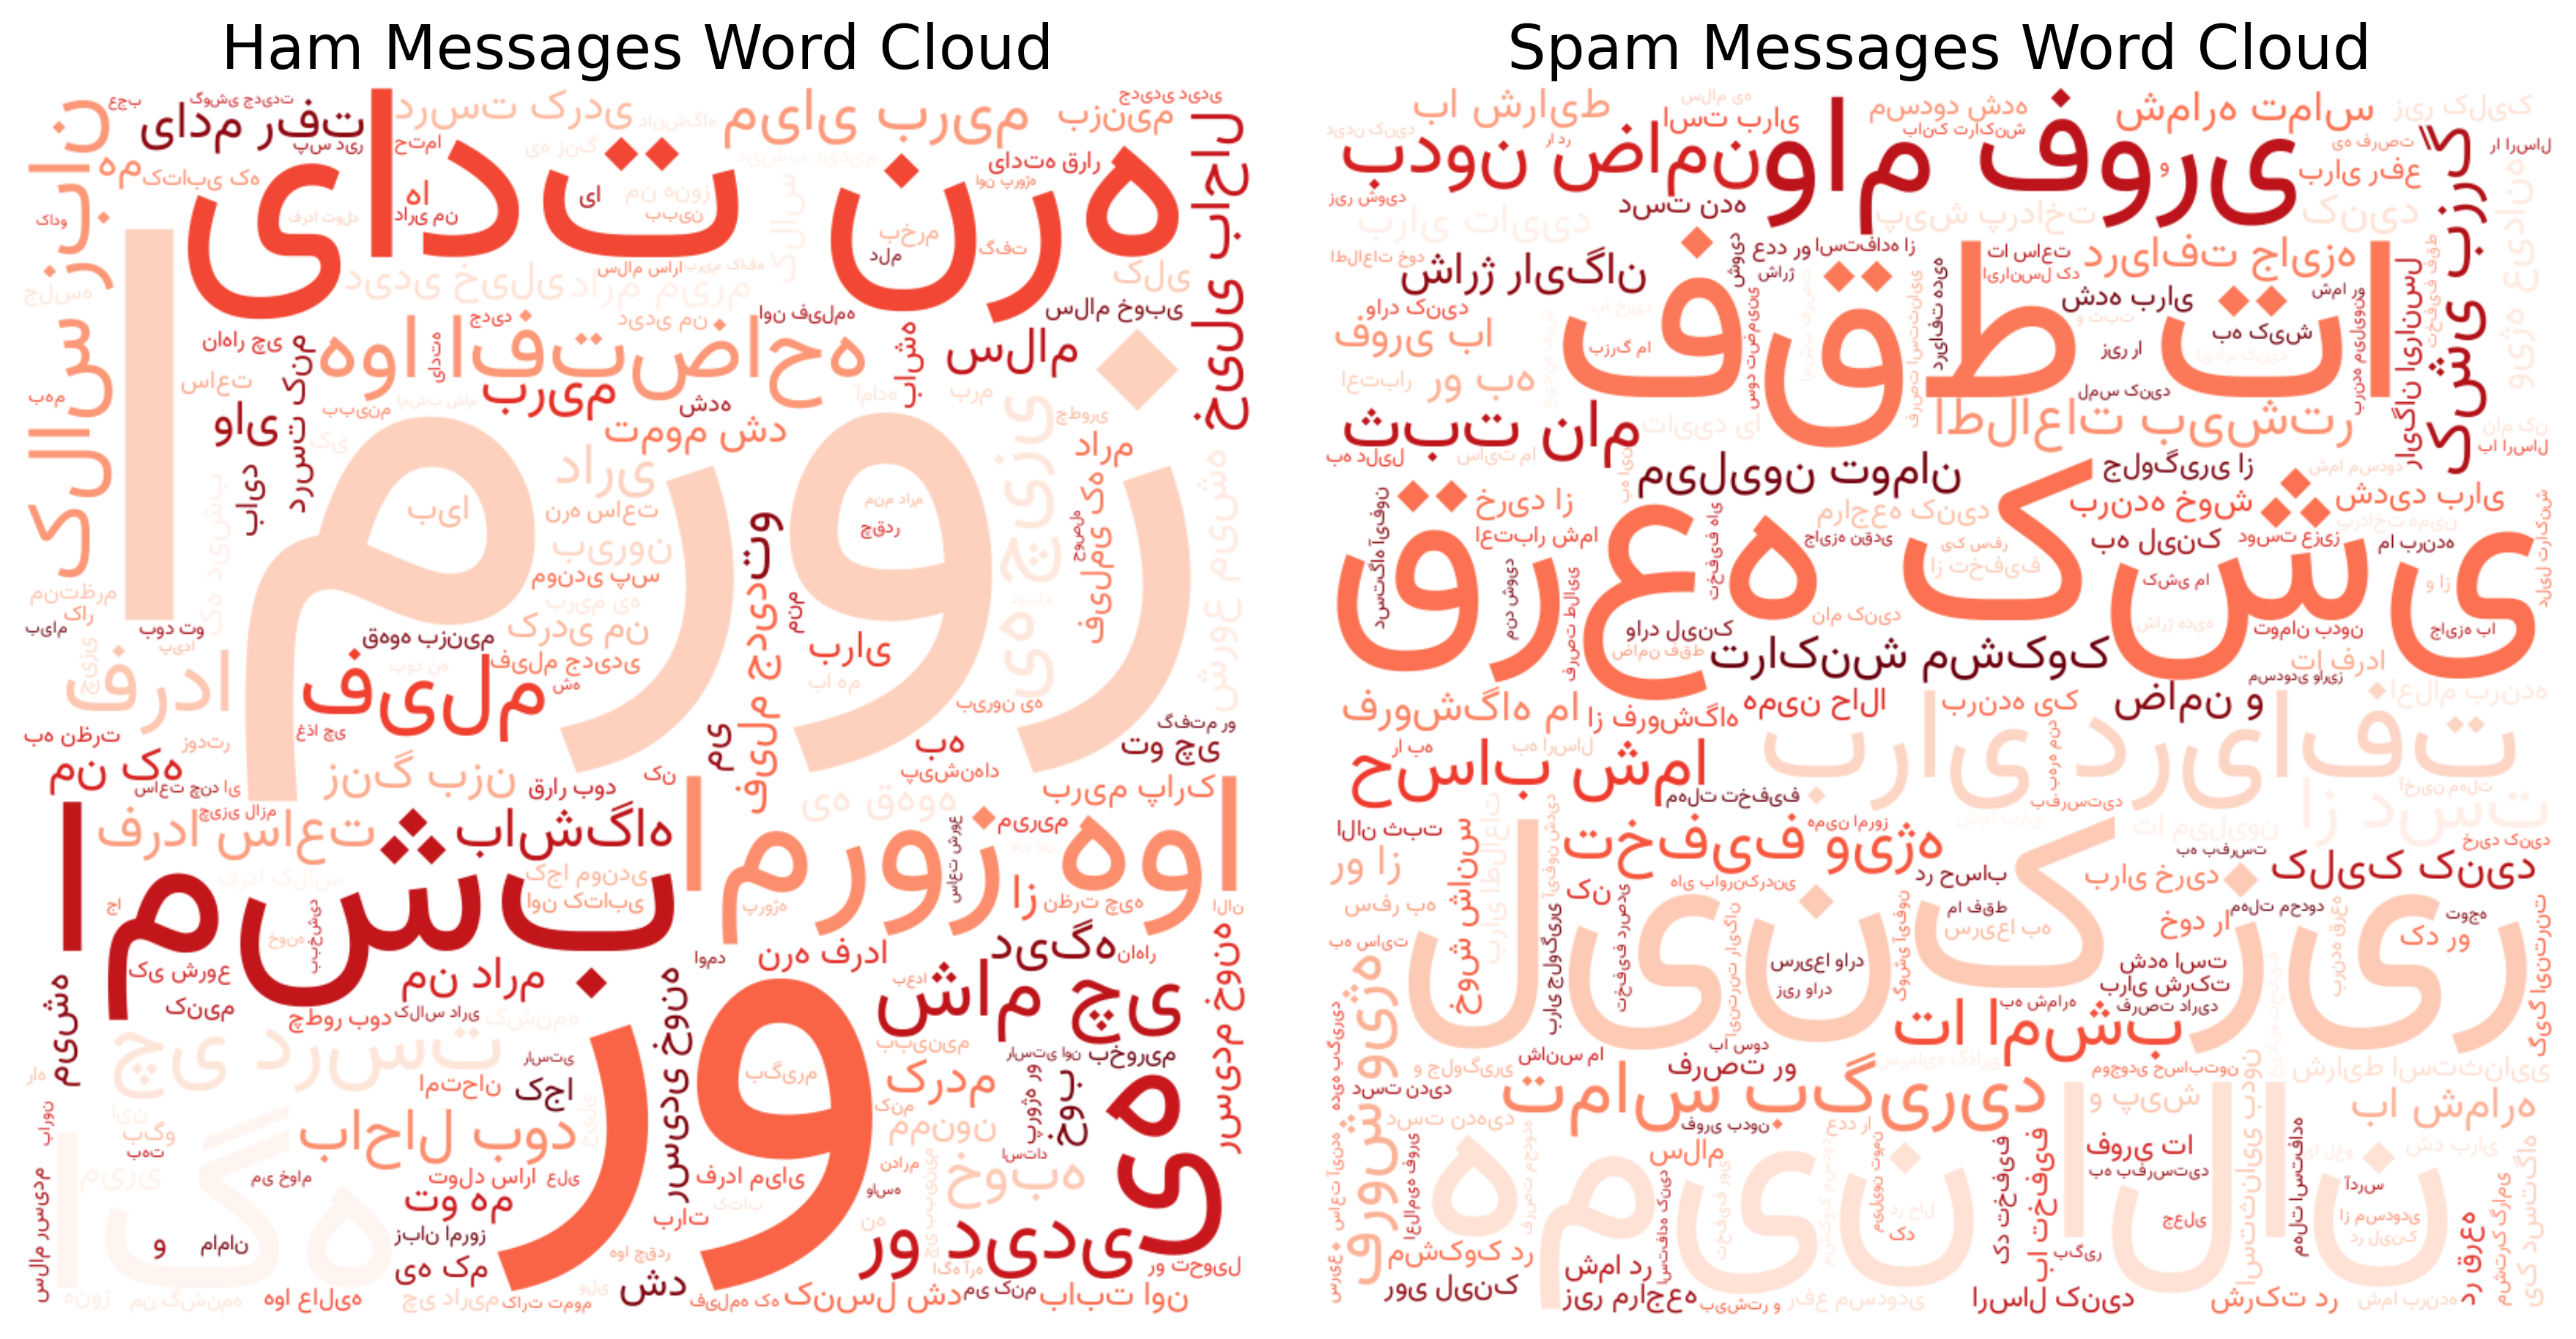

In [18]:
red_palette_c = sns.color_palette("Reds_r", as_cmap=True)

ham_text = " ".join(df[df['Class'] == "ham"]['Text'].astype(str))
spam_text = " ".join(df[df['Class'] == "spam"]['Text'].astype(str))

font_path ="../../../Data/Farsi/Font/Vazirmatn-VariableFont_wght.ttf"
ham_wordcloud = WordCloud(width=800, height=800, background_color='white', colormap=red_palette_c, font_path=font_path).generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=800, background_color='white', colormap=red_palette_c, font_path=font_path).generate(spam_text)

ham_image = ham_wordcloud.to_array()
spam_image = spam_wordcloud.to_array()

plt.figure(figsize=(12, 6), dpi=300)

plt.subplot(1, 2, 1)
plt.imshow(ham_image, interpolation='bilinear')
plt.title('Ham Messages Word Cloud', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_image, interpolation='bilinear')
plt.title('Spam Messages Word Cloud', fontsize=20)
plt.axis('off')

plt.tight_layout()

plt.savefig('../../../Data/Farsi/2. Synthetic/Word Cloud.png', format='png', dpi=1000)

plt.show()


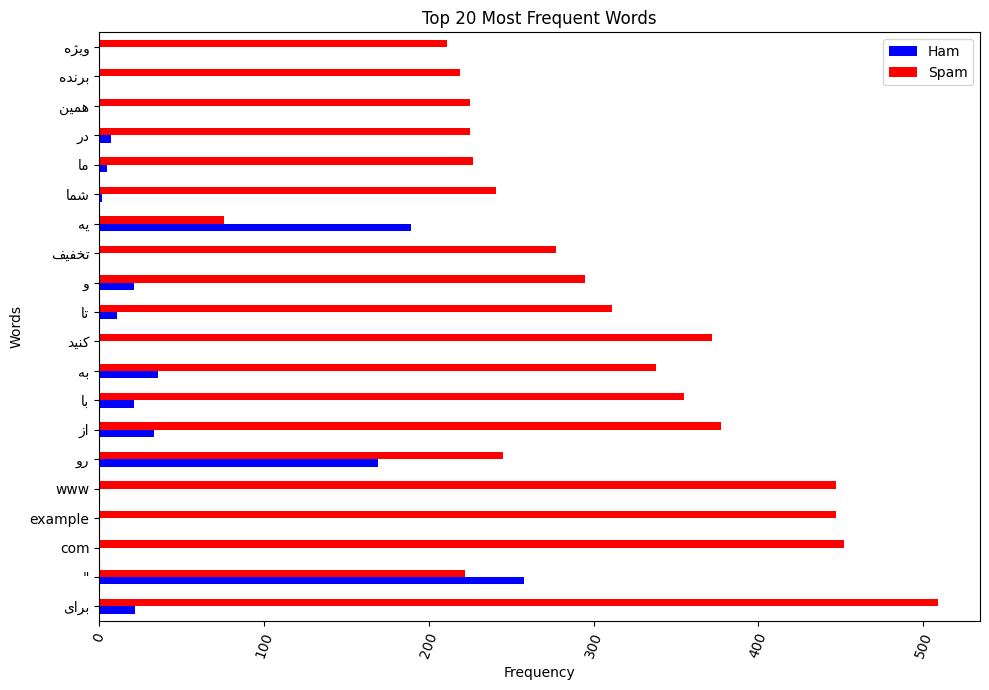

In [19]:
# Function to clean and tokenize the text
def clean_and_tokenize(text):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)
    unwanted_patterns = r'[\/:?\.\،\؛!«»؟]|^\d+$|^(https?|ir)$'
    tokens = [token for token in tokens if not re.match(unwanted_patterns, token)]
    return tokens

# Prepare and clean text
ham_text = " ".join(df[df['Class'] == "ham"]['Text'].astype(str))
spam_text = " ".join(df[df['Class'] == "spam"]['Text'].astype(str))
ham_words = clean_and_tokenize(ham_text)
spam_words = clean_and_tokenize(spam_text)

# Calculate term frequency and combine into a single DataFrame
ham_word_counts = pd.Series(ham_words).value_counts()
spam_word_counts = pd.Series(spam_words).value_counts()
combined_word_counts = pd.DataFrame({'Ham': ham_word_counts, 'Spam': spam_word_counts}).fillna(0)

# Calculate the total frequency for sorting
combined_word_counts['Total'] = combined_word_counts.sum(axis=1)

# Sort the DataFrame by total frequency
combined_word_counts = combined_word_counts.sort_values(by='Total', ascending=False)

# Get the top 20 most frequent words
top_words = combined_word_counts.head(20)

# Drop the 'Total' column after sorting
top_words = top_words.drop(columns='Total')

# Reshape and display Farsi text
reshaped_labels = [get_display(reshape(label)) for label in top_words.index]

# Plot term frequency bar chart for the top 20 most frequent words
fig, ax = plt.subplots(figsize=(10, 7))

top_words.plot(kind='barh', ax=ax, color=['blue', 'red'])
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.xticks(rotation=70, ha='center')

# Apply reshaped Farsi labels to the y-axis ticks
ax.set_yticklabels(reshaped_labels)

plt.tight_layout()

plt.savefig('../../../Data/Farsi/2. Synthetic/Top 20 Most Frequent Words.png', format='png', dpi=1000)

plt.show()



as you can see the most freqyency words are the mostly stopwords

# Preprocecing


here I have difined 8 functions, each one for a task.

In [20]:
def remove_urls(text):
    """Replaces URLs in the text with <URL>."""
    extractor = URLExtract()
    urls = extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, "<URL>")
    return text

def normalize_text(text):
    """Normalizes the text using Hazm normalizer."""
    normalizer = Normalizer()
    return normalizer.normalize(text)

def convert_emojis(text):
    """Converts emojis to text descriptions using emoji library."""
    return emoji.demojize(text, language='fa')

def handle_punctuation(text):
    """Handles punctuation by removing unwanted characters."""
    unwanted_patterns = r'[\/:?\.\،\؛!«»؟]'
    return re.sub(unwanted_patterns, '', text)

def tokenize_text(text):
    """Tokenizes the text using Hazm word tokenizer."""
    tokenizer = word_tokenize
    return tokenizer(text)

def lemmatize_tokens(tokens):
    """Lemmatizes each token in the list."""
    lemmatizer = Lemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def remove_stopwords(tokens):
    """Removes stopwords from the list of tokens."""
    stopwords = stopwords_list()
    return [token for token in tokens if token not in stopwords]

def join_tokens(tokens):
    """Joins the list of tokens back into a sentence."""
    return ' '.join(tokens)

here I have difined a final function which uses previous functions

In [ ]:
# # Preprocess each step separately with progress bars
# tqdm.pandas()

# # Step 1: Remove URLs
# print("Removing URLs......")
# df['Text'] = df['Text'].progress_apply(remove_urls)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_synthetic_farsi_sms.csv', index=False)

# # Step 2: Normalize text
# print("Normalizing text.......")
# df['Text'] = df['Text'].progress_apply(normalize_text)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_synthetic_farsi_sms.csv', index=False)

# # Step 3: Convert emojis
# print("Converting emojis.......")
# df['Text'] = df['Text'].progress_apply(convert_emojis)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_synthetic_farsi_sms.csv', index=False)

# # Step 4: Handle punctuation
# print("Handling punctuation.......")
# df['Text'] = df['Text'].progress_apply(handle_punctuation)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_synthetic_farsi_sms.csv', index=False)

# # Step 5: Tokenize text
# print("Tokenizing text.......")
# df['Tokens'] = df['Text'].progress_apply(tokenize_text)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_synthetic_farsi_sms.csv', index=False)

# # Step 6: Lemmatize tokens
# print("Lemmatizing tokens.......")
# df['Tokens'] = df['Tokens'].progress_apply(lemmatize_tokens)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_synthetic_farsi_sms.csv', index=False)

# # Step 7: Remove stopwords
# print("Removing stopwords.......")
# df['Tokens'] = df['Tokens'].progress_apply(remove_stopwords)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_synthetic_farsi_sms.csv', index=False)

# # Step 8: Join tokens back into a sentence
# print("Joining tokens back into a sentence.......")
# df['Text'] = df['Tokens'].progress_apply(join_tokens)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_synthetic_farsi_sms.csv', index=False)

# print("Preprocessing complete and saved at each step.")

Removing URLs......


100%|██████████| 1914/1914 [00:19<00:00, 100.71it/s]


Normalizing text.......


100%|██████████| 1914/1914 [56:50<00:00,  1.78s/it] 


Converting emojis.......


100%|██████████| 1914/1914 [00:00<00:00, 19894.08it/s]


Handling punctuation.......


100%|██████████| 1914/1914 [00:00<00:00, 398624.45it/s]


Tokenizing text.......


100%|██████████| 1914/1914 [00:00<00:00, 111195.88it/s]


Lemmatizing tokens.......


100%|██████████| 1914/1914 [20:37<00:00,  1.55it/s]


Removing stopwords.......


100%|██████████| 1914/1914 [00:00<00:00, 5942.22it/s]


Joining tokens back into a sentence.......


100%|██████████| 1914/1914 [00:00<00:00, 455276.92it/s]

Preprocessing complete and saved at each step.


In [22]:
df = pd.read_csv("../../../Data/Farsi/3. Preprocessed/preprocessed_synthetic_farsi_sms.csv", encoding='UTF-8')

In [23]:
df

Text Class  NO_words  \
0     سلام یادم رفت#رو بهت بگم امتحان فیزیک انداختن ...   ham        18   
1     مهلت استفاده تسهیلات بانکی پایانه تمدید دریافت...  spam        25   
2     کلاس ساعت ۱۰ تشکیل میشه یادم رفت#رو بهت بگم زن...   ham        12   
3                    وایسا دم زود بیا منم داشت#دار میام   ham        11   
4     امروز تولد مامانمه چی‌کار کرد#کن سورپرایز کرد#...   ham        13   
...                                                 ...   ...       ...   
1909                    کلاس امروز فهمید#فهم هنگ کرد#کن   ham        10   
1910  فروش پاییز تخفیف ۷۰ ٪ محصولات فرصت دست داد#ده ...  spam        22   
1911                   سلام شام چی داشت#دار امشب گرسنمه   ham         9   
1912                       برد#بر باشگاه بعدا زنگ زد#زن   ham         8   
1913     سلام امشب فیلم چی دید#بین یه باشه آدمو بخندونه   ham        14   

      NO_characters  NO_sentences  NO_emojis  \
0                71             2          0   
1               108             3          0   
2                47             2          1   
3                36             2          0   
4                61             3          0   
...             ...           ...        ...   
1909             37             2          0   
1910             85             3          0   
1911             32             2          0   
1912             32             2          0   
1913             56             3          0   

                                                 Tokens  
0     ['سلام', 'یادم', 'رفت#رو', 'بهت', 'بگم', 'امتح...  
1     ['مهلت', 'استفاده', 'تسهیلات', 'بانکی', 'پایان...  
2     ['کلاس', 'ساعت', '۱۰', 'تشکیل', 'میشه', 'یادم'...  
3     ['وایسا', 'دم', 'زود', 'بیا', 'منم', 'داشت#دار...  
4     ['امروز', 'تولد', 'مامانمه', 'چی\u200cکار', 'ک...  
...                                                 ...  
1909    ['کلاس', 'امروز', 'فهمید#فهم', 'هنگ', 'کرد#کن']  
1910  ['فروش', 'پاییز', 'تخفیف', '۷۰', '٪', 'محصولات...  
1911  ['سلام', 'شام', 'چی', 'داشت#دار', 'امشب', 'گرس...  
1912       ['برد#بر', 'باشگاه', 'بعدا', 'زنگ', 'زد#زن']  
1913  ['سلام', 'امشب', 'فیلم', 'چی', 'دید#بین', 'یه'...  

[1914 rows x 7 columns]

In [24]:
# Replace text labels 'ham' and 'spam' with 0 and 1 in the 'Class' column
df["Class"].replace({"ham": 0, "spam": 1}, inplace=True)

In [25]:
# Text Vectorization using TF-IDF for the 'Text' Column
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(df['Text'])
Y = df["Class"]

In [26]:
# Splitting data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=24)

In [27]:
# Classifier models
svm = SVC(kernel='sigmoid', gamma=1.0, class_weight='balanced')
knn = KNeighborsClassifier()
mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()
dt = DecisionTreeClassifier(max_depth=5)
lr = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced')
rf = RandomForestClassifier(n_estimators=50, random_state=2, class_weight='balanced')
ada = AdaBoostClassifier(n_estimators=50, random_state=2)
bagging = BaggingClassifier(n_estimators=50, random_state=2)
et = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2, tree_method='gpu_hist')
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
ridge = RidgeClassifier()
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=2)
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=2)


In [28]:
# Add models to the dictionary
models = {
    'SVM': svm,
    'KNN': knn,
    'MultinomialNB': mnb,
    'GaussianNB': gnb,
    'BernoulliNB': bnb,
    'DT': dt,
    'LR': lr,
    'RF': rf,
    'AdaBoost': ada,
    'Bagging': bagging,
    'ExtraTrees': et,
    'GBDT': gbdt,
    'XGB': xgb,
    'LDA': lda,
    'QDA': qda,
    'Ridge': ridge,
    'SGD': sgd,
    'Perceptron': perceptron
}

In [29]:
def train_classifier(model, X_train, Y_train, X_test, Y_test, dense_data=None):
    # Use precomputed dense data if provided
    if isinstance(model, (GaussianNB, QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis)):
        if dense_data is None:
            print(f"Converting sparse data to dense for {type(model).__name__}")
            X_train = X_train.toarray()
            X_test = X_test.toarray()
        else:
            X_train, X_test = dense_data
    
    # Train the model
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='binary')
    recall = recall_score(Y_test, y_pred, average='binary')
    f1 = f1_score(Y_test, y_pred, average='binary')
    return accuracy, precision, recall, f1, y_pred

In [30]:
# Enable logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Train models sequentially
results = []
for name, model in models.items():
    try:
        accuracy, precision, recall, f1, y_pred = train_classifier(model, X_train, Y_train, X_test, Y_test)
        results.append((name, accuracy, precision, recall, f1))
    except Exception as e:
        logger.error(f"Error occurred while training model {name}: {e}")

# Log final results
logger.info("\nFinal Results:")
for name, accuracy, precision, recall, f1 in results:
    logger.info(f"{name}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

Converting sparse data to dense for GaussianNB
Converting sparse data to dense for LinearDiscriminantAnalysis
Converting sparse data to dense for QuadraticDiscriminantAnalysis


INFO:__main__:
Final Results:
INFO:__main__:SVM: Accuracy=0.9974, Precision=1.0000, Recall=0.9945, F1 Score=0.9972
INFO:__main__:KNN: Accuracy=0.9896, Precision=0.9836, Recall=0.9945, F1 Score=0.9890
INFO:__main__:MultinomialNB: Accuracy=0.9948, Precision=0.9891, Recall=1.0000, F1 Score=0.9945
INFO:__main__:GaussianNB: Accuracy=0.9948, Precision=0.9945, Recall=0.9945, F1 Score=0.9945
INFO:__main__:BernoulliNB: Accuracy=0.9974, Precision=1.0000, Recall=0.9945, F1 Score=0.9972
INFO:__main__:DT: Accuracy=0.9582, Precision=1.0000, Recall=0.9116, F1 Score=0.9538
INFO:__main__:LR: Accuracy=0.9948, Precision=0.9945, Recall=0.9945, F1 Score=0.9945
INFO:__main__:RF: Accuracy=0.9974, Precision=1.0000, Recall=0.9945, F1 Score=0.9972
INFO:__main__:AdaBoost: Accuracy=0.9739, Precision=1.0000, Recall=0.9448, F1 Score=0.9716
INFO:__main__:Bagging: Accuracy=0.9922, Precision=1.0000, Recall=0.9834, F1 Score=0.9916
INFO:__main__:ExtraTrees: Accuracy=0.9922, Precision=0.9944, Recall=0.9890, F1 Score=0.99

In [31]:
# Create a DataFrame to store and compare the accuracy, precision, recall, and F1 scores of the different algorithms
performance_df = pd.DataFrame({
    'Algorithm': [name for name, _, _, _, _ in results],
    'Accuracy': [accuracy for _, accuracy, _, _, _ in results],
    'Precision': [precision for _, _, precision, _, _ in results],
    'Recall': [recall for _, _, _, recall, _ in results],
    'F1 Score': [f1 for _, _, _, _, f1 in results]
})

.
.
.
.
### lets sort the sort the results by 'F1 Score' in descending order

In [32]:
# Sort the DataFrame by 'F1 Score' in descending order
performance_df = performance_df.sort_values('F1 Score', ascending=False)

# Reset the index to ensure it is sequential
performance_df = performance_df.reset_index(drop=True)

In [33]:
performance_df

Algorithm  Accuracy  Precision    Recall  F1 Score
0             SVM  0.997389   1.000000  0.994475  0.997230
1     BernoulliNB  0.997389   1.000000  0.994475  0.997230
2              RF  0.997389   1.000000  0.994475  0.997230
3             XGB  0.997389   1.000000  0.994475  0.997230
4   MultinomialNB  0.994778   0.989071  1.000000  0.994505
5      GaussianNB  0.994778   0.994475  0.994475  0.994475
6             SGD  0.994778   0.994475  0.994475  0.994475
7              LR  0.994778   0.994475  0.994475  0.994475
8           Ridge  0.994778   0.994475  0.994475  0.994475
9      ExtraTrees  0.992167   0.994444  0.988950  0.991690
10        Bagging  0.992167   1.000000  0.983425  0.991643
11            KNN  0.989556   0.983607  0.994475  0.989011
12     Perceptron  0.989556   0.988950  0.988950  0.988950
13           GBDT  0.989556   1.000000  0.977901  0.988827
14            LDA  0.981723   0.994318  0.966851  0.980392
15       AdaBoost  0.973890   1.000000  0.944751  0.971591
16             DT  0.958225   1.000000  0.911602  0.953757
17            QDA  0.425587   0.440729  0.801105  0.568627

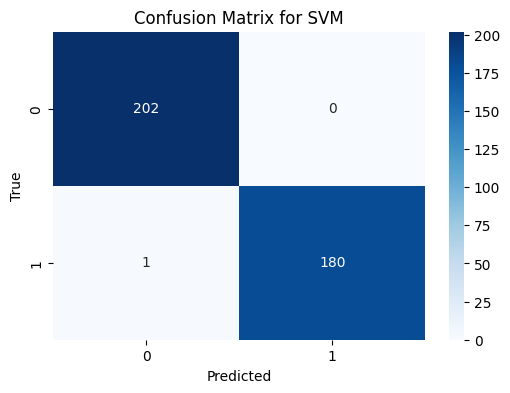

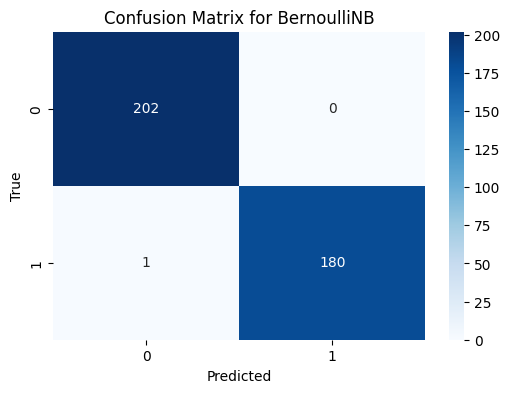

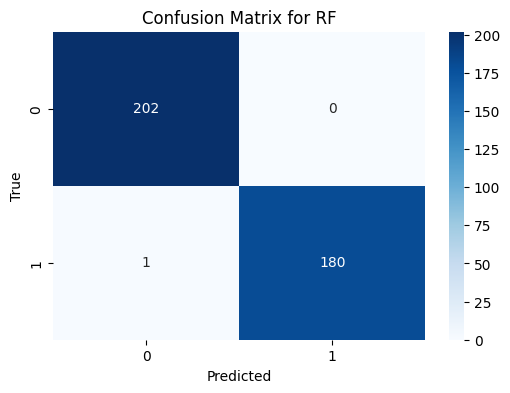

In [34]:
# Plot confusion matrices for top 3 models
top_models = performance_df.head(3)['Algorithm']
for name in top_models:
    model = models[name]
    _, _, _, _, y_pred = train_classifier(model, X_train, Y_train, X_test, Y_test)
    cm = confusion_matrix(Y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

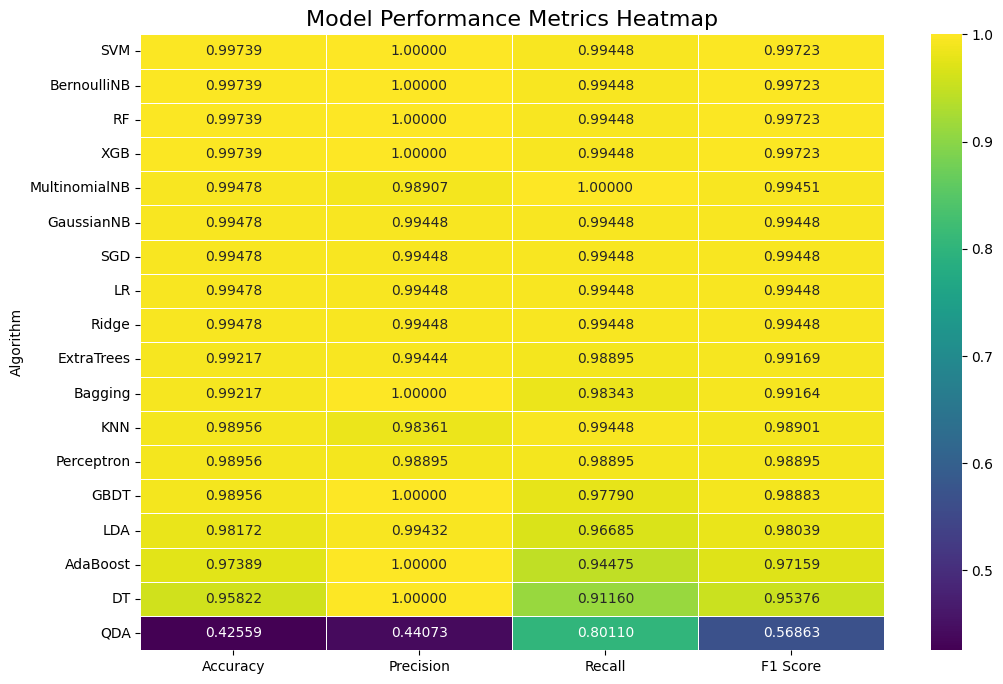

In [35]:
#  Heatmap
plt.figure(figsize=(12, 8))
metrics = performance_df.set_index('Algorithm')[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
sns.heatmap(metrics, annot=True, cmap='viridis', fmt=".5f", linewidths=0.5)
plt.title('Model Performance Metrics Heatmap', fontsize=16)

# Save the chart as an image
plt.savefig('Results/Train_synthetic_farsi_sms/heatmap_model_performance_chart.png', dpi=600, bbox_inches='tight')

# Show the chart
plt.show()

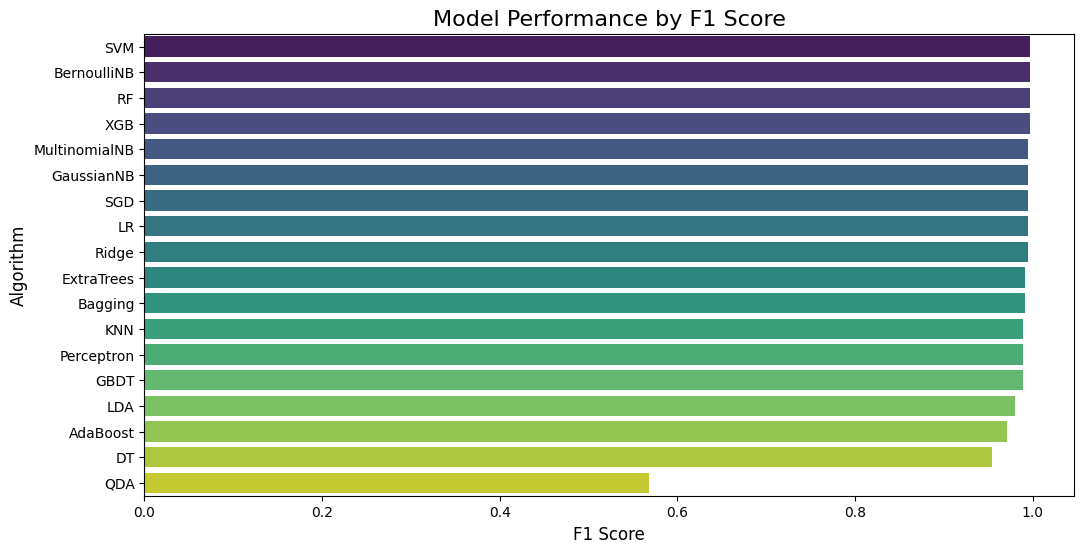

In [36]:
# Bar plot for F1 Score
plt.figure(figsize=(12, 6))
sns.barplot(x='F1 Score', y='Algorithm', data=performance_df, palette='viridis')
plt.title('Model Performance by F1 Score', fontsize=16)
plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Algorithm', fontsize=12)

# Save the chart as an image
plt.savefig('Results/Train_synthetic_farsi_sms/barplot_model_performance.png', dpi=600, bbox_inches='tight')

# Show the chart
plt.show()